<a href="https://colab.research.google.com/github/fafnirkyu/data-challenge-alura/blob/main/Semana_2_data_sciece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DoubleType, StructField

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050')\
    .getOrCreate()

In [4]:
dados = spark.read.parquet('/content/drive/MyDrive/dadossemana1')

Contando nulos nas colunas area_total e area_util

In [5]:
from pyspark.sql.functions import col,isnan,when,count
df_Columns=["area_total","area_util"]
dados.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
   ).toPandas()
#area total: 9186
#area util: sem nulos

,area_total,area_util
0,9186,0


Contando numero de valores destintos em cada coluna e retirando valores com apenas um valor

In [6]:
for columns in dados:
    uniquecount = dados.select(columns).distinct().count()
    print(columns, 'possui', uniquecount, 'valor(es) diferente(s)')

Column<'id'> possui 66348 valor(es) diferente(s)
Column<'andar'> possui 53 valor(es) diferente(s)
Column<'quartos'> possui 14 valor(es) diferente(s)
Column<'suites'> possui 14 valor(es) diferente(s)
Column<'area_total'> possui 695 valor(es) diferente(s)
Column<'area_util'> possui 592 valor(es) diferente(s)
Column<'banheiros'> possui 18 valor(es) diferente(s)
Column<'caracteristicas'> possui 6964 valor(es) diferente(s)
Column<'bairro'> possui 154 valor(es) diferente(s)
Column<'zona'> possui 5 valor(es) diferente(s)
Column<'tipo_anuncio'> possui 1 valor(es) diferente(s)
Column<'tipo_unidade'> possui 1 valor(es) diferente(s)
Column<'tipo_uso'> possui 1 valor(es) diferente(s)
Column<'vaga'> possui 42 valor(es) diferente(s)
Column<'condominio'> possui 3345 valor(es) diferente(s)
Column<'iptu'> possui 5113 valor(es) diferente(s)
Column<'tipo'> possui 1 valor(es) diferente(s)
Column<'valor'> possui 9743 valor(es) diferente(s)


In [7]:
dadosregressao = dados.drop('pais', 'tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'area_total', 'tipo')

In [8]:
dadosregressao.show(5)

+--------------------+-----+-------+------+---------+---------+--------------------+--------------------+----------+----+----------+----+-----+
|                  id|andar|quartos|suites|area_util|banheiros|     caracteristicas|              bairro|      zona|vaga|condominio|iptu|valor|
+--------------------+-----+-------+------+---------+---------+--------------------+--------------------+----------+----+----------+----+-----+
|d2e3a3aa-09b5-45a...|    3|      2|  null|       43|        1|[Academia, Churra...|           Paciência|Zona Oeste|   1|       245|null|15000|
|085bab2c-87ad-452...|    2|      2|  null|       42|        1|[Churrasqueira, P...|           Paciência|Zona Oeste|   1|         0|   0|15000|
|18d22cbe-1b86-476...|    1|      2|  null|       41|        1|[Portaria 24h, Co...|           Guaratiba|Zona Oeste|   1|         0|   0|20000|
|bed8a354-9317-442...|    3|      2|  null|       43|        1|[Churrasqueira, P...|              Cosmos|Zona Oeste|   0|       285|null

Convertendo "andar", "banheiros", "suites" e "quartos" para o tipo inteiro e "area_util", "condominio", "iptu" e "valor" para o tipo double.

In [9]:
dadosregressao = dadosregressao.withColumn('andar', dados['andar'].cast(IntegerType()))\
.withColumn('banheiros', dadosregressao['banheiros'].cast(IntegerType()))\
.withColumn('suites', dadosregressao['suites'].cast(IntegerType()))\
.withColumn('quartos', dadosregressao['quartos'].cast(IntegerType()))\
.withColumn('area_util', dadosregressao['area_util'].cast(DoubleType()))\
.withColumn('condominio', dadosregressao['condominio'].cast(DoubleType()))\
.withColumn('iptu', dadosregressao['iptu'].cast(DoubleType()))\
.withColumn('valor', dadosregressao['valor'].cast(DoubleType()))
dadosregressao.printSchema()


root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



Tratando dados nulos

In [10]:
dadosregressao = dadosregressao\
    .select('*')\
    .na\
    .fill(0)

Transformação de variáveis categóricas

In [12]:
from pyspark.sql import functions as f
from pyspark.sql.functions import explode
zona = dadosregressao\
    .groupBy("id")\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)
zona.show(4)

+--------------------+---+------------+----------+----------+--------+
|                  id|   |Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+---+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|  0|           0|         0|         0|       1|
|02fba6ef-a691-442...|  0|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|  0|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|  0|           0|         0|         0|       1|
+--------------------+---+------------+----------+----------+--------+
only showing top 4 rows



In [13]:
import pyspark.sql.functions as f
dadosregressao.select(f.explode('caracteristicas')).distinct().show()

lista_caracteristicas = ['condominio_fechado','playground','portao_eletronico','piscina','animais_permitidos',\
                         'portaria_24h','elevador','academia','salao_de_festas','churrasqueira']

for coluna in lista_caracteristicas:
  dadosregressao = dadosregressao.withColumn(coluna,f.when(f.array_contains(f.col("caracteristicas"),coluna) == 'true',f.lit(1)).otherwise(0))

dadosregressao.show(5,truncate=False)

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+

+------------------------------------+-----+-------+------+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+---------+----------+----+----------+----+-------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|id                                  |andar|quartos|suites|area_util|banheiros|caracteristicas                                                                                                                |bairro   |zona      |vaga|condominio|iptu|valor  |condominio_fechado|playground|portao_eletronico|piscin

In [14]:
bairro = dadosregressao\
    .groupBy("id")\
    .pivot('bairro')\
    .agg(f.lit(1))\
    .na\
    .fill(0)
bairro.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+----------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+--

In [15]:
dadosregressao = dadosregressao\
    .join(zona, 'id', how='inner')

Salvando dados

In [16]:
dadosregressao.write.parquet('/content/drive/MyDrive/dadossemana2',  mode = 'overwrite')

Vetorização

In [17]:
from pyspark.ml.feature import VectorAssembler
dadosml = dadosregressao.withColumnRenamed('valor','label')
X =['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'condominio_fechado',
 'playground',
 'portao_eletronico',
 'piscina',
 'animais_permitidos',
 'portaria_24h',
 'elevador',
 'academia',
 'salao_de_festas',
 'churrasqueira',
 'Zona Norte',
 'Zona Oeste',
 'Zona Central',
 'Zona Sul']
assembler = VectorAssembler(inputCols = X, outputCol = 'features')
dataset_prep = assembler.transform(dadosml).select('features', 'label')
dataset_prep.show(5, truncate=False)

+-------------------------------------------------------------------+---------+
|features                                                           |label    |
+-------------------------------------------------------------------+---------+
|(22,[1,2,3,4,6,7,21],[90.0,2.0,3.0,1.0,950.0,2677.0,1.0])          |949020.0 |
|(22,[0,1,2,3,4,5,6,7,19],[3.0,64.0,1.0,2.0,2.0,1.0,784.0,80.0,1.0])|380000.0 |
|(22,[1,2,3,4,5,6,7,18],[82.0,2.0,3.0,1.0,1.0,1515.0,133.0,1.0])    |580000.0 |
|(22,[1,2,3,4,5,6,7,21],[170.0,3.0,4.0,1.0,1.0,2250.0,3000.0,1.0])  |1450000.0|
|(22,[1,2,3,4,5,6,7,21],[525.0,4.0,4.0,2.0,2.0,5000.0,2100.0,1.0])  |5199000.0|
+-------------------------------------------------------------------+---------+
only showing top 5 rows



Modelo de regressão

In [18]:
from pyspark.ml.regression import LinearRegression
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)
lr = LinearRegression()
modelo_lr = lr.fit(treino)  
previsoes_lr_treino = modelo_lr.transform(treino)
previsoes_lr_treino.show(5)

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(22,[0,1,2,3,4,5,...|299000.0|147498.15521413766|
|(22,[0,1,2,3,4,5,...|330000.0|157485.22832115603|
|(22,[0,1,2,3,4,5,...| 99000.0|207536.31435300587|
|(22,[0,1,2,3,4,5,...|329000.0|238120.23904680964|
|(22,[0,1,2,3,4,5,...|369500.0| 285783.2267945643|
+--------------------+--------+------------------+
only showing top 5 rows



Métricas

In [19]:
resumo_treino = modelo_lr.summary
resumo_teste = modelo_lr.evaluate(teste)
r2_lr_tre = resumo_treino.r2
rmse_lr_tre = resumo_treino.rootMeanSquaredError
r2_lr_tes = resumo_teste.r2
rmse_lr_tes =  resumo_teste.rootMeanSquaredError
print('R² treino :', r2_lr_tre)
print('RMSE treino :', rmse_lr_tre)
print('R² teste :', r2_lr_tes)
print('RMSE teste :', rmse_lr_tes)

R² treino : 0.6680852828272495
RMSE treino : 844163.0879653998
R² teste : 0.6451284732928633
RMSE teste : 881823.6837181106


Gradient-boosted tree regression

In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

df = assembler.transform(dadosml).select('features', 'label')
gbt = GBTRegressor(featuresCol='features', labelCol='label', maxIter=15)
gbt.setMaxIter(5)
gbt.setMinWeightFractionPerNode(0.049)
model = gbt.fit(treino)
predic_gbt = model.transform(treino)

rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(predic_gbt) 
r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(predic_gbt)

print('R² GBT :', r2)
print('RMSE GBT :', rmse)

R² GBT : 0.6563526677794409
RMSE GBT : 858953.3776642409


Cross Validation

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
    .build()
evaluator = BinaryClassificationEvaluator()
#cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cv = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)
cv_model = cv.fit(treino)
best_model = cv_model.bestModel

resumo_treino = best_model.summary
resumo_teste = best_model.evaluate(teste)
r2_lr_tre = resumo_treino.r2
rmse_lr_tre = resumo_treino.rootMeanSquaredError
r2_lr_tes = resumo_teste.r2
rmse_lr_tes =  resumo_teste.rootMeanSquaredError
print('R² treino :', r2_lr_tre)
print('RMSE treino :', rmse_lr_tre)
print('R² teste :', r2_lr_tes)
print('RMSE teste :', rmse_lr_tes)

#print(cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)])


R² treino : 0.6680852798876346
RMSE treino : 844163.0917035808
R² teste : 0.6451284279625111
RMSE teste : 881823.7400390236


Análise de correlação

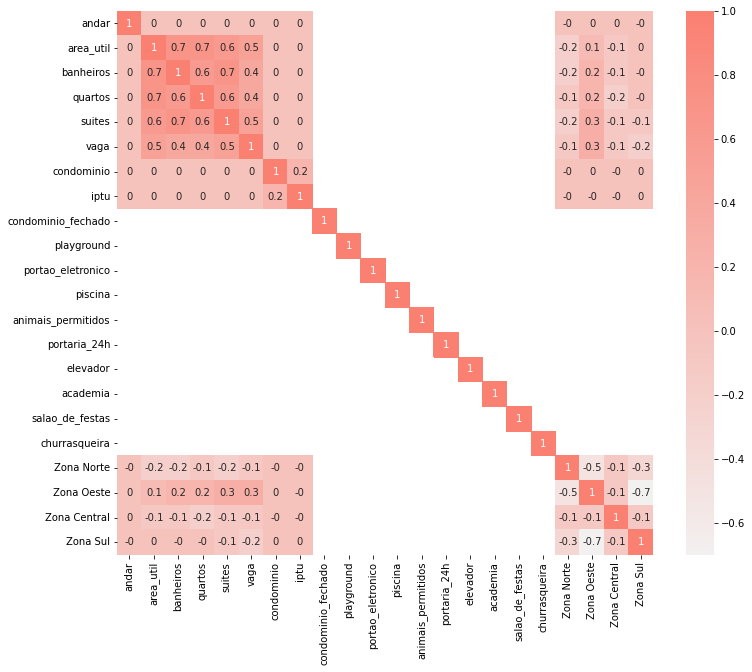

In [22]:
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)